<a href="https://colab.research.google.com/github/VGGatGitHub/AnswerFlow/blob/master/jsonl2json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code transfroms jsonl to json and helps look at the training data set ...
for the 200nq data there are three problematic long answers related to the follwing two html tags: \<Ul\> \<Li\>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(os.getcwd())

/content


In [0]:
#VGG define the foldre to inspect for files 
path='/content/drive/My Drive/Colab Notebooks/'

In [4]:
#make sure the file you need is in the correct directory 

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/chatbot_v2 (1).ipynb
/content/drive/My Drive/Colab Notebooks/train.json
/content/drive/My Drive/Colab Notebooks/loding_files.ipynb
/content/drive/My Drive/Colab Notebooks/Copy of qa.ipynb
/content/drive/My Drive/Colab Notebooks/chatbot_v2.ipynb
/content/drive/My Drive/Colab Notebooks/simplified-nq-train.jsonl
/content/drive/My Drive/Colab Notebooks/chatbot_v3.ipynb
/content/drive/My Drive/Colab Notebooks/train200l.json
/content/drive/My Drive/Colab Notebooks/text_utils.py
/content/drive/My Drive/Colab Notebooks/jsonl2json.ipynb
/content/drive/My Drive/Colab Notebooks/chatbot_v6.ipynb
/content/drive/My Drive/Colab Notebooks/__pycache__/text_utils.cpython-36.pyc


In [0]:
#VGG import the jsonl file to convert into json and wtite it out
io_filename='simplified-nq-train' 

#will append jsonl and json as extentions later
input_file=path+io_filename+'.jsonl'

#saving the file in the working directory 
out_file=path+'train200.json' 


In [0]:
# VGG 
# Original repository https://github.com/google-research-datasets/natural-questions
# you could also get the file text_utils.py from https://github.com/VGGatGitHub/natural-questions
#

sys.path.append(os.path.abspath(path))
from text_utils import *

In [0]:
import json
import pandas as pd
import gc
import sys
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

def read_data(path, sample = True, chunksize = 30000):
    if sample == True:
        df = []
        with open(path, 'rt') as reader:
            for i in range(chunksize):
                try:
                    line = reader.readline()
                    if not line.strip():
                        continue
                    df.append(json.loads(line))
                except:
                    print(line)
                    print(sys.exc_info())

        df = pd.DataFrame(df)
        print('Our sampled dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Our dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df




In [8]:
#create and save the json file

train = read_data(input_file)

small_train = []
for i in range(200): #200 VGG change the nuber of data sets
    row_dict = train.loc[i].to_dict()
    doc = simplify_nq_example(row_dict) #VGG for simple json formated file
    small_train.append(doc)

with open(out_file, "w") as outfile:
    json.dump(small_train, outfile, indent=2, cls=NpEncoder)


Our sampled dataset have 200 rows and 9 columns


In [9]:
train.head()

,annotations,document_html,document_title,document_tokens,document_url,example_id,long_answer_candidates,question_text,question_tokens
0,"[{'annotation_id': 6782080525527814293, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",The Walking Dead (season 8),"[{'end_byte': 95, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Th...,4549465242785278785,"[{'end_token': 216, 'start_token': 24, 'top_le...",when is the last episode of season 8 of the wa...,"[when, is, the, last, episode, of, season, 8, ..."
1,"[{'annotation_id': 7719528322202775345, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Persephone,"[{'end_byte': 102, 'html_token': False, 'start...",https://en.wikipedia.org//w/index.php?title=Pe...,-2543388002166163252,"[{'end_token': 217, 'start_token': 24, 'top_le...",in greek mythology who was the goddess of spri...,"[in, greek, mythology, who, was, the, goddess,..."
2,"[{'annotation_id': 13676402902866580638, 'long...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Colony (biology),"[{'end_byte': 98, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Co...,5985355041383167183,"[{'end_token': 126, 'start_token': 18, 'top_le...",benefits of colonial life for single celled or...,"[benefits, of, colonial, life, for, single, ce..."
3,"[{'annotation_id': 7446307064203576492, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",The Man in the High Castle (TV series),"[{'end_byte': 95, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Th...,-2975172535563055798,"[{'end_token': 473, 'start_token': 30, 'top_le...",how many season of the man in the high castle,"[how, many, season, of, the, man, in, the, hig..."
4,"[{'annotation_id': 3569531263672159632, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",List of heads of state of Nigeria,"[{'end_byte': 96, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Li...,-1052334833502528495,"[{'end_token': 203, 'start_token': 24, 'top_le...",who was the first ministry head of state in ni...,"[who, was, the, first, ministry, head, of, sta..."


{'annotations': [{'annotation_id': 7719528322202775345,
   'long_answer': {'candidate_index': 58,
    'end_token': 965,
    'start_token': 809},
   'short_answers': [{'end_token': 838, 'start_token': 814}],
   'yes_no_answer': 'NONE'}],
 'document_html': '<!DOCTYPE html>\n<HTML class="client-js ve-not-available" lang="en" dir="ltr"><HEAD>\n\n<TITLE>Persephone - Wikipedia</TITLE>\n\n\n<LINK rel="stylesheet" href="/w/load.php?debug=false&amp;lang=en&amp;modules=ext.cite.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cmediawiki.legacy.commonPrint%2Cshared%7Cmediawiki.skinning.interface%7Cmediawiki.toc.styles%7Cskins.vector.styles%7Cwikibase.client.init&amp;only=styles&amp;skin=vector" />\n\n<STYLE>\n.mw-spinner{background-color:transparent;background-position:center center;background-repeat:no-repeat}.mw-spinner-small{background-image:url();background-image:url(/w/resources/src/jquery.spinner/images/spinner.gif?ca65b)!ie;height:20px;
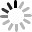

In [16]:
train.loc[1].to_dict()

In [17]:
simplify_nq_example(train.loc[1].to_dict())

{'annotations': [{'annotation_id': 7719528322202775345,
   'long_answer': {'candidate_index': 58,
    'end_token': 965,
    'start_token': 809},
   'short_answers': [{'end_token': 838, 'start_token': 814}],
   'yes_no_answer': 'NONE'}],
 'document_text': 'Persephone - Wikipedia <H1> Persephone </H1> This article is about the Greek goddess . For other uses , see Persephone ( disambiguation ) . <Table> <Tr> <Th_colspan="2"> Persephone </Th> </Tr> <Tr> <Td_colspan="2"> Goddess of the underworld , springtime , flowers and vegetation </Td> </Tr> <Tr> <Td_colspan="2"> Statue of Persephone with a sistrum . Heraklion Archaeological Museum , Crete </Td> </Tr> <Tr> <Th> Abode </Th> <Td> The Underworld , Sicily , Mount Olympus </Td> </Tr> <Tr> <Th> Symbol </Th> <Td> Pomegranate , Seeds of Grain , Torch , Flowers and Deer </Td> </Tr> <Tr> <Th_colspan="2"> </Th> </Tr> <Tr> <Th> Spouse </Th> <Td> Hades </Td> </Tr> <Tr> <Th> Children </Th> <Td> Melinoe , Zagreus </Td> </Tr> <Tr> <Th> Parents </Th> <T

In [18]:
small_train[1]

{'annotations': [{'annotation_id': 7719528322202775345,
   'long_answer': {'candidate_index': 58,
    'end_token': 965,
    'start_token': 809},
   'short_answers': [{'end_token': 838, 'start_token': 814}],
   'yes_no_answer': 'NONE'}],
 'document_text': 'Persephone - Wikipedia <H1> Persephone </H1> This article is about the Greek goddess . For other uses , see Persephone ( disambiguation ) . <Table> <Tr> <Th_colspan="2"> Persephone </Th> </Tr> <Tr> <Td_colspan="2"> Goddess of the underworld , springtime , flowers and vegetation </Td> </Tr> <Tr> <Td_colspan="2"> Statue of Persephone with a sistrum . Heraklion Archaeological Museum , Crete </Td> </Tr> <Tr> <Th> Abode </Th> <Td> The Underworld , Sicily , Mount Olympus </Td> </Tr> <Tr> <Th> Symbol </Th> <Td> Pomegranate , Seeds of Grain , Torch , Flowers and Deer </Td> </Tr> <Tr> <Th_colspan="2"> </Th> </Tr> <Tr> <Th> Spouse </Th> <Td> Hades </Td> </Tr> <Tr> <Th> Children </Th> <Td> Melinoe , Zagreus </Td> </Tr> <Tr> <Th> Parents </Th> <T

In [25]:
# Explore the structure of the json file 
UNKNOWN = "<UNKNOWN>"

with open(out_file) as json_file: #VGG
        data = json.load(json_file)
        n_long=0 #VGG
        n_short=0 
        doc_n=0
        n_surprises=0

        for nq_doc in data:
            doc_n+=1
            doc = nq_doc #VGG simplify_nq_example(nq_doc)
            #VGG document_title = nq_doc['document_title']
            document_title = doc['document_text'].split('H1>')[1][:-2]

            question_text = doc['question_text']
            annotations = doc['annotations'][0]          
            document_text = doc['document_text'].split()

            long_answer_candidates = doc['long_answer_candidates']
            
            print("\n")
            print(doc_n,"Document Title: ",document_title)
            print("Question: ",question_text)

            if len(annotations['short_answers']) > 0:
                start_token = annotations['short_answers'][0]['start_token']
                end_token = annotations['short_answers'][0]['end_token']
                short_answer = " ".join(document_text[start_token:end_token])
                print("Short Answer: ", short_answer)
                n_short+=1 #VGG
            else:
                short_answer = UNKNOWN

            long_answer = " ".join(
                document_text[annotations['long_answer']['start_token']:
                              annotations['long_answer']['end_token']])
            problem = True
            if annotations['long_answer']['start_token'] == annotations['long_answer']['end_token']: 
              print("Problem: no long answer present!")
            else:
              n_long+=1
              n_posibilities=0
              for posibilities in long_answer_candidates:
                  if posibilities["top_level"]:
                      n_posibilities+=1
                      start_token = posibilities['start_token']
                      end_token = posibilities['end_token']
                      posibility = " ".join(document_text[start_token:end_token])
                      if posibility == long_answer: 
                        problem = False
                        print("the long answer was found to be possibility ",n_posibilities)
                  else:
                      pass 
             
            #VGG V3# context.append(preprocess_sentence(long_answer))
                   
            if problem == True : 
              print("Long answer problem in example_id:",doc['example_id'])
              print("Long answer:",long_answer) 
              print("Posibilities:", n_posibilities) 
              print("start_token:",annotations['long_answer']['start_token'])
              print("end_token:",annotations['long_answer']['end_token'])  
              if short_answer != UNKNOWN or annotations['long_answer']['start_token'] != annotations['long_answer']['end_token']:
                print("Surprise! Short Answer present or Mismatch!")
                n_surprises+=1
                #break
                                
        print()
        print(n_short,"short answers out of",len(data), "possible, rate is",100*n_short/len(data),"%")
        print(n_long,"long answers out of",len(data), "possible, rate is",100*n_long/len(data),"%")
        print("there were :", n_surprises," surprises!")




1 Document Title:   The Walking Dead ( season 8 ) 
Question:  when is the last episode of season 8 of the walking dead
Short Answer:  March 18 , 2018
the long answer was found to be possibility  18


2 Document Title:   Persephone 
Question:  in greek mythology who was the goddess of spring growth
Short Answer:  Persephone ( / pərˈsɛfəni / ; Greek : Περσεφόνη ) , also called Kore ( / ˈkɔːriː / ; `` the maiden '' )
the long answer was found to be possibility  4


3 Document Title:   Colony ( Biology ) 
Question:  benefits of colonial life for single celled organisms
Problem: no long answer present!
Long answer problem in example_id: 5985355041383167183
Long answer: 
Posibilities: 61
start_token: -1
end_token: -1


4 Document Title:   The Man in the High Castle ( TV series ) 
Question:  how many season of the man in the high castle
the long answer was found to be possibility  1


5 Document Title:   List of heads of state of Nigeria 
Question:  who was the first ministry head of state 